# <span style="color: navy">Bike Sharing Demand </span>

### From: https://www.kaggle.com/c/bike-sharing-demand

## Background:

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

## Evaluation:

Our target optimization metric is the Root Mean Squared Logarithmic Error (RMSLE), which is computed
as follows:

<img src="RMSLE.png">

>### Where:
<b><i>n</i> is the number of hours in the test set<br>
<i>p<sub>i</sub></i> is your predicted count<br>
<i>a<sub>i</sub></i> is the actual count<br>
log(<i>x</i>) is the natural logarithm<br></b>


## Understanding the data:

In the following paragraph we will explore the data and highlight the main conclusions we observed:<br>

It is clear to us that there are two kinds of customers:
**registered and casual, which have significant different behavior patterns.**<br>
By exploring the registered vs. casual rentals across the day of the week graph, or casual rentals across the hour of the day, it is clear that registered customers use the bike as a means of transportation from and to work (as seen as peeks at 07:00 and 17:00-18:00).
Furthermore, we can see a high demand with registered users on Mon-Fri, while the casual users use the bike more often on non-working days.<br>
We also saw that during the spring season the demand for bikes rentals is relatively low for both casual and registered. We assume that the main reason for that is the low temperature.<br>
We used a scatter matrix to observe the correlation between the different weather features.<br>
We plan to use PCA as a feature reduction method on the weather features.<br>
The scatter matrix also revealed a few outliers, which will be omitted.<br>
The features Temperatures, "Feels Like" Temperatures & Humidity seems to have a normal distribution, while the Windspeed feature seems to have a skewed distribution (perhaps log-normal or B). These observations will allow us to better pick the scaling transformers.  
The Windspeed feature has 1313 samples with 0 speed and then, 1120 with 8. This may urge us to use a digitizer transformer or an estimator in order to adjust these samples (zero wind speed).

# <span style="color: green">Part I – pre-processing

Data Fields:

datetime: hourly date + timestamp  

season:  
1 = spring,   
2 = summer,   
3 = fall,  
4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 
1: Clear, Few clouds, Partly cloudy, Partly cloudy 
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from pandas.tools.plotting import scatter_matrix
from sklearn.model_selection import train_test_split as split
from pandas.plotting import scatter_matrix
from pandas.api.types import CategoricalDtype
import warnings

# warnings.filterwarnings('ignore')
%matplotlib inline
# %matplotlib notebook

In [2]:
raw_data =  pd.read_csv('train.csv', header=0,  sep=',')
# raw_data.head()

In [3]:
bikeData = raw_data.copy()

#### **Renaming 'count' to 'total'**

In [4]:
bikeData.rename(columns={'count':'total'}, inplace=True)

#### **Converting datetime column fron str to DatetimeIndex:**

In [5]:
bikeData['datetime'] = pd.DatetimeIndex(bikeData.datetime)

In [6]:
dayofweek_dict = {0: 'Mon',1: 'Tue',2: 'Wed',3: 'Thu',4: 'Fri',5: 'Sat',6: 'Sun'}
season_dict = {1: 'Spring',2: 'Summer',3: 'Fall',4: 'Winter'}

bikeData['season'] = bikeData['season'].apply(lambda x:season_dict[x]) 
# bikeData['year'] = bikeData['datetime'].apply(lambda x:x.year) 
bikeData['month'] = bikeData['datetime'].apply(lambda x:x.month)
# bikeData['day'] = bikeData['datetime'].apply(lambda x:x.day) 
bikeData['hour'] = bikeData['datetime'].apply(lambda x:x.hour)
bikeData['month'] = bikeData['datetime'].apply(lambda x:x.month)
bikeData['weekday'] = bikeData['datetime'].apply(lambda x:dayofweek_dict[x.dayofweek])  # 0 is mon,1 is tue etc

#### **Dropping Unncessary Columns**

In [7]:
bikeData.drop(["datetime"], axis=1, inplace=True)

In [8]:
bikeData.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,month,hour,weekday
0,Spring,0,0,1,9.84,14.395,81,0.0,3,13,16,1,0,Sat
1,Spring,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,Sat
2,Spring,0,0,1,9.02,13.635,80,0.0,5,27,32,1,2,Sat
3,Spring,0,0,1,9.84,14.395,75,0.0,3,10,13,1,3,Sat
4,Spring,0,0,1,9.84,14.395,75,0.0,0,1,1,1,4,Sat


#### **Coercing To Category Types**

In [9]:
weekdayOrder = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
t = CategoricalDtype(categories=weekdayOrder, ordered=True)
bikeData.weekday = pd.Series(bikeData.weekday, dtype=t)
# bikeData.weekday.cat.ordered

In [10]:
seasonOrder = ['Spring', 'Summer','Fall', 'Winter']
t = CategoricalDtype(categories=seasonOrder, ordered=True)
bikeData.season = pd.Series(bikeData.season, dtype=t)
#bikeData.season.cat.ordered

In [11]:
for var in ['hour','month','weather','holiday','workingday']:
    bikeData[var] = bikeData[var].astype('category')

In [12]:
bikeData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 14 columns):
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
total         10886 non-null int64
month         10886 non-null category
hour          10886 non-null category
weekday       10886 non-null category
dtypes: category(7), float64(3), int64(4)
memory usage: 672.0 KB


In [13]:
bikeData.describe()

,temp,atemp,humidity,windspeed,casual,registered,total
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


# <span style="color:blue">Distinguish casual from registered customer: </span>

In [15]:
def plot_bar_2y (df ) :
    col1 = df.columns[0]
    col2 = df.columns[1]
    fig = plt.figure(figsize=(10, 6)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    width = 0.4
    df[col1].plot(kind='bar', color='red',ax=ax, width=width, position=1,table = False)
    df[col2].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
    ax.set_ylabel(col1)
    ax2.set_ylabel(col2)
    
    plt.show()
def plot_pie (df) :
    col1 = df.columns[0]
    col2 = df.columns[1]
    explode_list = [0.05] * len (df)
   
    fig3= plt.figure(figsize=(10,6))
    ax1 = plt.subplot(121,aspect='equal',adjustable='box-forced',autoscale_on=False)
    pie_1 = df[col1].plot(kind = 'pie',ax = ax1,startangle = 0 ,shadow = False
                          ,legend = False,autopct = '%1.1f%%', fontsize = 14
                          ,radius = 0.9,table = False,explode = explode_list)
    ax2 = plt.subplot(122,aspect='equal',adjustable='box-forced',autoscale_on=False)
    pie_2 = df[col2].plot(kind = 'pie',ax = ax2,startangle = 0 ,shadow = False
                                                             ,legend = False,autopct = '%1.1f%%', fontsize = 14
                                                             ,radius = 0.9,table = False,explode = explode_list)
    fig3.tight_layout()
    plt.show()

## Showing registered vs. casual rentals across day of the week

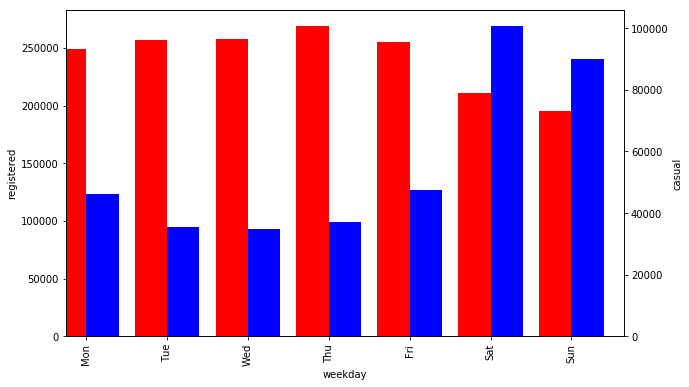

In [16]:
bikeData_dayofweek= bikeData.groupby('weekday').agg({'casual':'sum','registered': 'sum'})
plot_bar_2y(bikeData_dayofweek)

## Showing registered vs. casual rentals across hour of the day

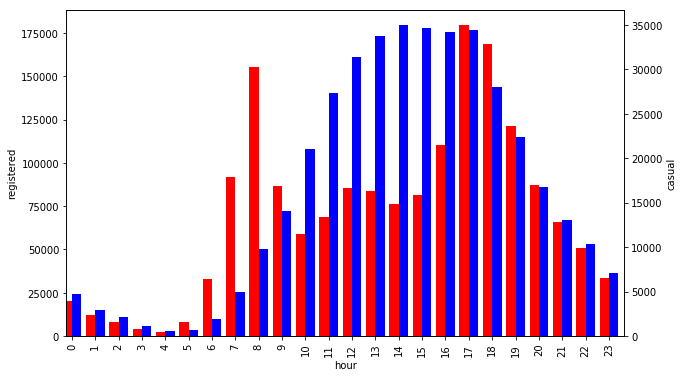

In [17]:
bikeData_hour= bikeData.groupby('hour').agg({'casual':'sum','registered': 'sum'})
# bikeData_hour.casual = bikeData_hour.casual.apply(lambda x: 100 * x / float(bikeData_hour.casual.sum()))
# bikeData_hour.registered = bikeData_hour.registered.apply(lambda x: 100 * x / float(bikeData_hour.registered.sum()))
plot_bar_2y(bikeData_hour)

## Showing average users count by weekday & hour of the day across user type

[Text(0,0.5,u'Users Count'),
 Text(0.5,0,u'Hour Of The Day'),
 Text(0.5,1,u'Average Users Count By Hour Of The Day Across User Type'),
 None]

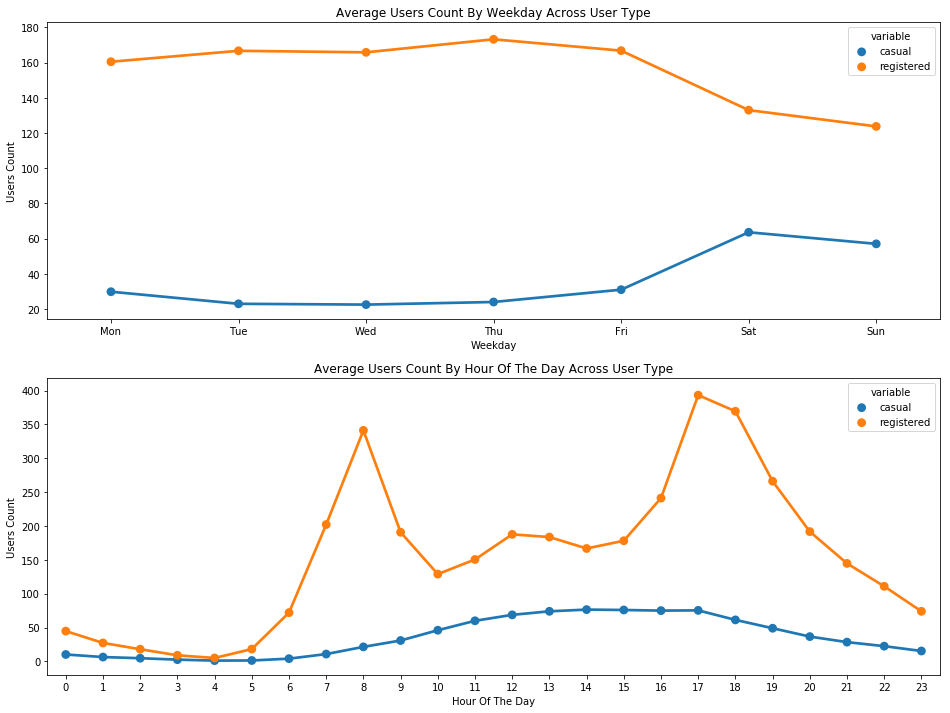

In [18]:
weekdayTransformed = pd.melt(bikeData[["weekday","casual","registered"]],
                          id_vars=['weekday'],
                          value_vars=['casual', 'registered'])
weekdayAggregated = pd.DataFrame(weekdayTransformed.groupby(["weekday","variable"], sort=True)
                                 ["value"].mean()).reset_index()
weekdayOrder = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

monthTransformed = pd.melt(bikeData[["month","casual","registered"]],
                          id_vars=['month'],
                          value_vars=['casual', 'registered'])

hourTransformed = pd.melt(bikeData[["hour","casual","registered"]],
                          id_vars=['hour'],
                          value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"], sort=True)["value"].mean()).reset_index()

registeredHourAggregated = pd.DataFrame(bikeData.groupby(["hour","weekday"],sort=True)["registered"].mean()).reset_index()

casualHourAggregated = pd.DataFrame(bikeData.groupby(["hour","weekday"],sort=True)["casual"].mean()).reset_index()

fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(16,12)
sn.pointplot(x=weekdayAggregated["weekday"],
             y=weekdayAggregated["value"],
             order=weekdayOrder,
             hue=weekdayAggregated["variable"],
             hue_order=["casual","registered"],
             data=weekdayAggregated,
             join=True, ax=ax1)
ax1.set(xlabel='Weekday',
       ylabel='Users Count',
       title="Average Users Count By Weekday Across User Type",
       label='big')

sn.pointplot(x=hourAggregated["hour"],
             y=hourAggregated["value"],
             hue=hourAggregated["variable"],
             hue_order=["casual","registered"],
             data=hourAggregated,
             join=True, ax=ax2)
ax2.set(xlabel='Hour Of The Day',
       ylabel='Users Count',
       title="Average Users Count By Hour Of The Day Across User Type",
       label='big')

## Showing registered vs. casual users count by hour of the day across weekdays

[Text(0,0.5,u'Casual Users Count'),
 Text(0.5,0,u'Hour Of The Day'),
 Text(0.5,1,u'Casual Users Count By Hour Of The Day Across Weekdays'),
 None]

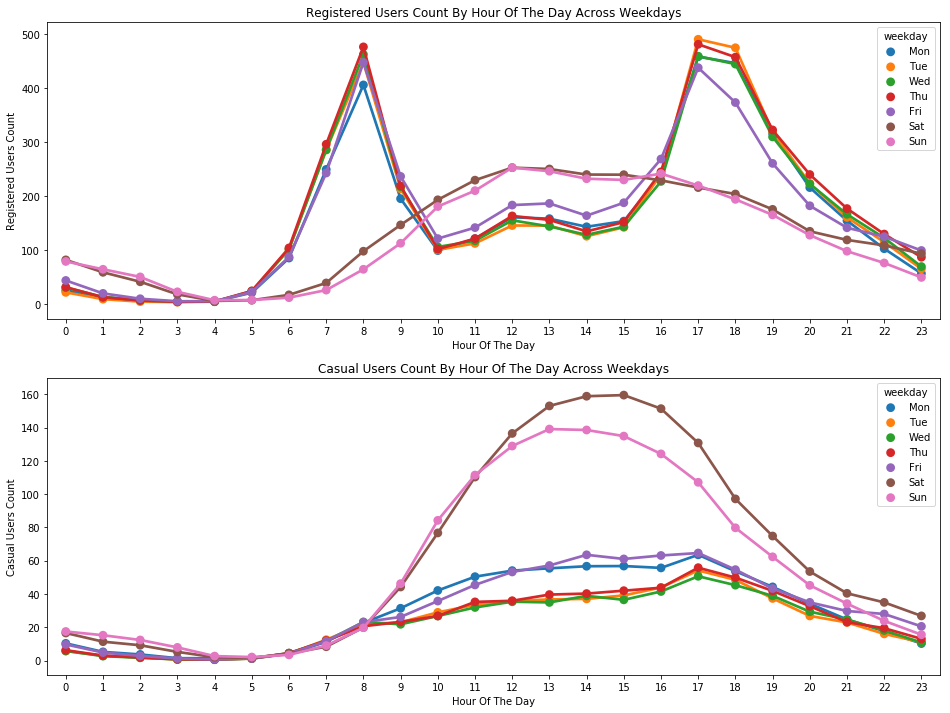

In [19]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(16,12)

casualHourAggregated = pd.DataFrame(bikeData.groupby(["hour","weekday"],sort=True)["casual"].mean()).reset_index()
registeredHourAggregated = pd.DataFrame(bikeData.groupby(["hour","weekday"],sort=True)["registered"].mean()).reset_index()

sn.pointplot(x=registeredHourAggregated["hour"],
             y=registeredHourAggregated["registered"],
             hue=registeredHourAggregated["weekday"],
             hue_order=weekdayOrder,
             data=registeredHourAggregated,
             join=True, ax=ax1)
ax1.set(xlabel='Hour Of The Day',
        ylabel='Registered Users Count',
        title="Registered Users Count By Hour Of The Day Across Weekdays",
        label='big')

sn.pointplot(x=casualHourAggregated["hour"],
             y=casualHourAggregated["casual"],
             hue=casualHourAggregated["weekday"],
             hue_order=weekdayOrder,
             data=casualHourAggregated,
             join=True, ax=ax2)
ax2.set(xlabel='Hour Of The Day',
        ylabel='Casual Users Count',
        title="Casual Users Count By Hour Of The Day Across Weekdays",
        label='big')


## Showing registered vs. casual rentals by working day

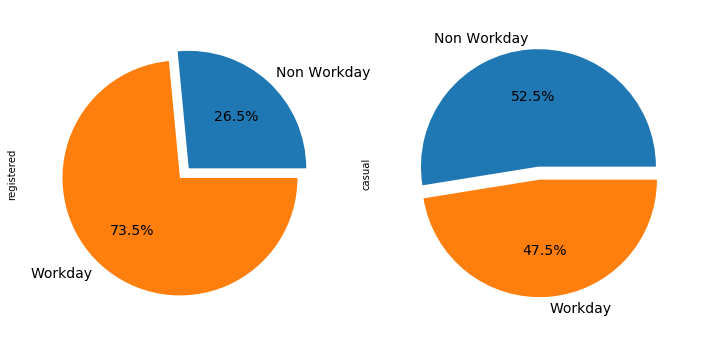

In [20]:
bikeData_workday = bikeData.groupby('workingday').agg({'casual':'sum','registered': 'sum'})
bikeData_workday.rename(index={0: 'Non Workday',1: 'Workday'}, inplace=True)
plot_pie(bikeData_workday)

## Showing registered vs. casual rentals by season

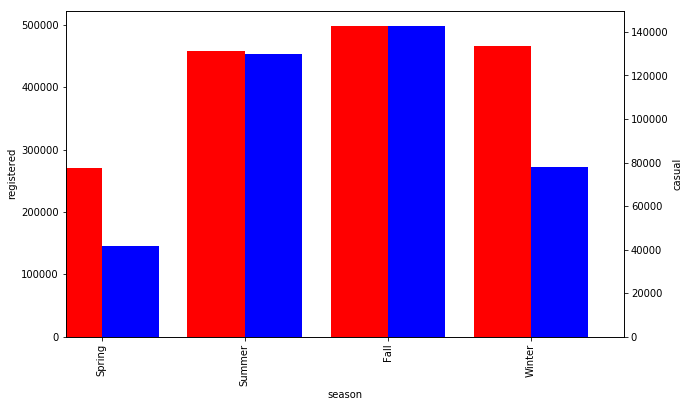

In [21]:
bikeData_season = bikeData.groupby('season').agg({'casual':'sum','registered': 'sum'})
plot_bar_2y(bikeData_season)

## Showing avarage temperatures by season

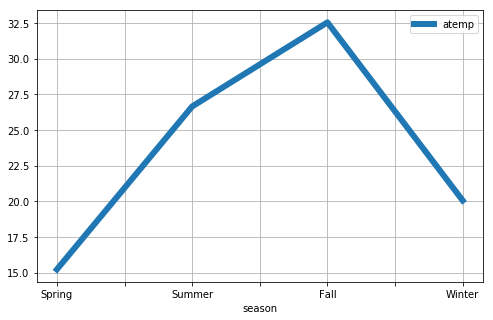

In [22]:
bikeData.groupby('season').agg({'atemp':'mean'}).plot(kind='line', linewidth=6.0, grid=True, figsize=(8, 5))

## Showing registered vs. casual users count by hour of the day across seasons

[Text(0,0.5,u'Casual Users Count'),
 Text(0.5,0,u'Hour Of The Day'),
 Text(0.5,1,u'Casual Users Count By Hour Of The Day Across Seasons'),
 None]

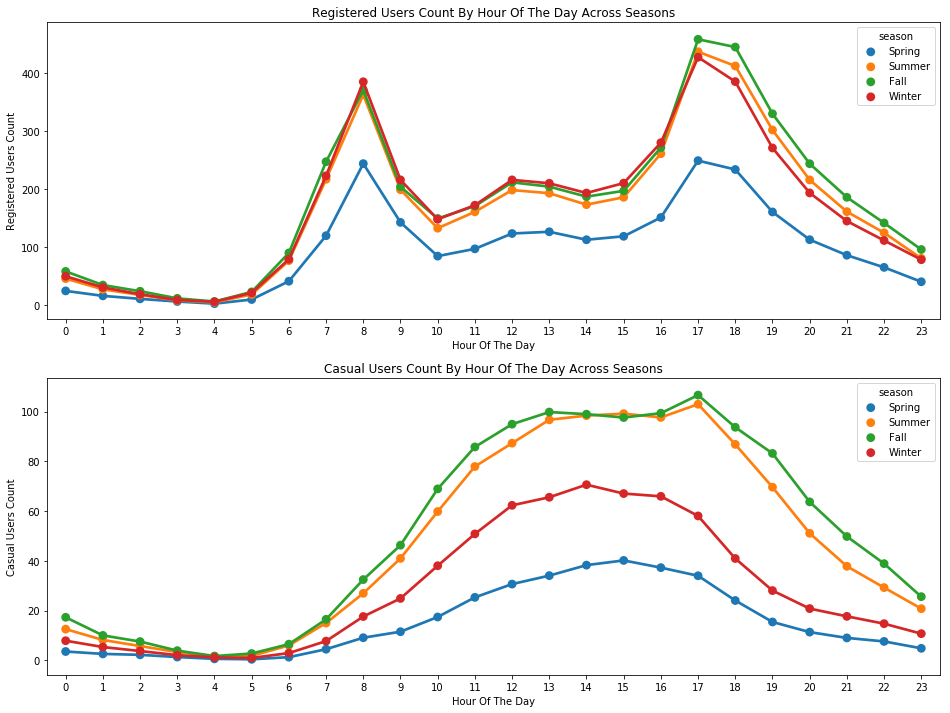

In [23]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(16,12)

casualHourAggregated = pd.DataFrame(bikeData.groupby(["hour","season"],sort=True)["casual"].mean()).reset_index()
registeredHourAggregated = pd.DataFrame(bikeData.groupby(["hour","season"],sort=True)["registered"].mean()).reset_index()

sn.pointplot(x=registeredHourAggregated["hour"],
             y=registeredHourAggregated["registered"],
             hue=registeredHourAggregated["season"],
             data=registeredHourAggregated,
             join=True, ax=ax1)
ax1.set(xlabel='Hour Of The Day',
        ylabel='Registered Users Count',
        title="Registered Users Count By Hour Of The Day Across Seasons",
        label='big')

sn.pointplot(x=casualHourAggregated["hour"],
             y=casualHourAggregated["casual"],
             hue=casualHourAggregated["season"],
             data=casualHourAggregated,
             join=True, ax=ax2)
ax2.set(xlabel='Hour Of The Day',
        ylabel='Casual Users Count',
        title="Casual Users Count By Hour Of The Day Across Seasons",
        label='big')


## Showing registered vs. casual rentals by weather

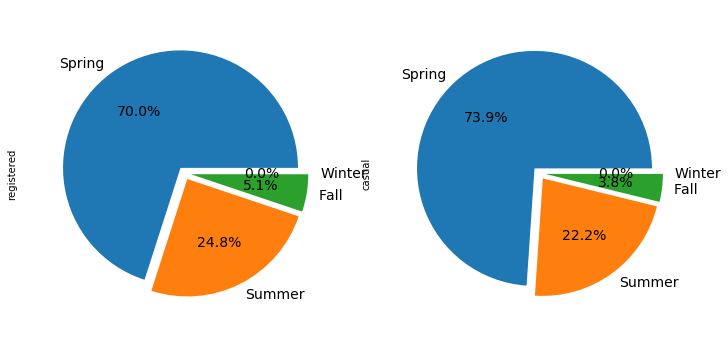

In [24]:
bikeData_weather = bikeData.groupby('weather').agg({'casual':'sum','registered': 'sum'})
bikeData_weather.rename(index={1: 'Spring',2: 'Summer',3: 'Fall',4: 'Winter'}, inplace=True)
plot_pie(bikeData_weather)

## Historgams of weather features:

## Temperatures:

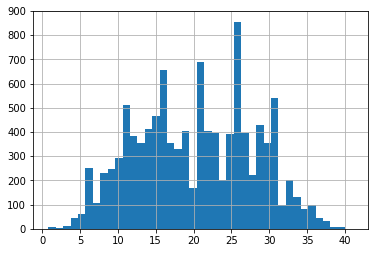

In [25]:
bikeData.temp.hist(bins=int(bikeData.temp.max()))

## "Feels Like" Temperatures:

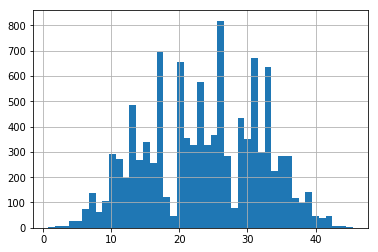

In [26]:
bikeData.atemp.hist(bins=int(bikeData.atemp.max()))## Humidity:

## Humidity:

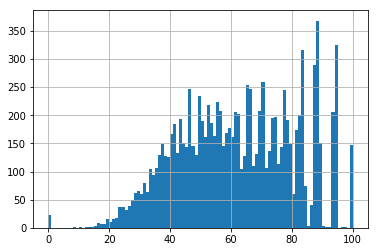

In [27]:
bikeData.humidity.hist(bins=int(bikeData.humidity.max()))

## Windspeed:

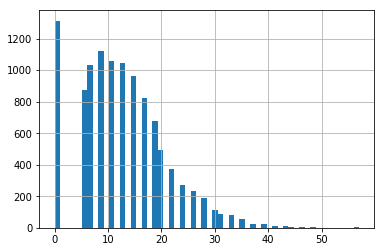

In [28]:
bikeData.windspeed.hist(bins=int(bikeData.windspeed.max()))### Removing humidity < 10 outliers:

## Scatter Matrix of weather features:

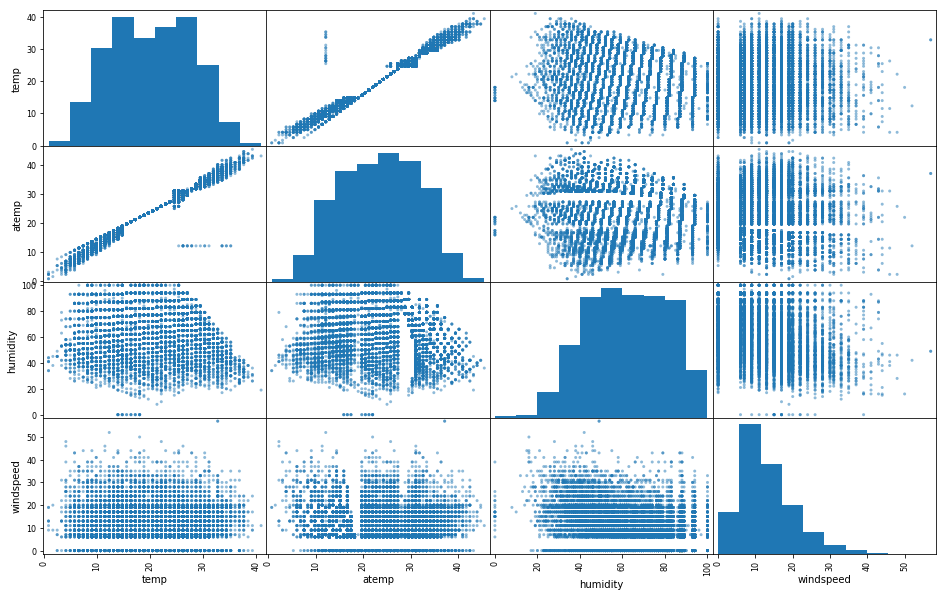

In [29]:
scatter = scatter_matrix(bikeData[['temp','atemp','humidity','windspeed']],  alpha=0.5, figsize=(16, 10))

### Removing humidity < 10 outliers:

In [30]:
bikeData.humidity.count()

10886

In [31]:
bikeData[bikeData.humidity < 10].humidity.count()

23

In [32]:
bikeData = bikeData[bikeData.humidity > 10]

### Removing windspeed > 45 outliers:

In [33]:
bikeData.windspeed.count()

10862

In [34]:
bikeData[bikeData.windspeed > 45].humidity.count()

9

In [35]:
bikeData = bikeData[bikeData.windspeed < 45]

### Removing temperature outliers:

In [36]:
bikeData.humidity.count()

10853

In [37]:
bikeData[(bikeData.atemp < 15) & (bikeData.temp > 25)].atemp.count()

24

In [38]:
bikeData.drop(bikeData[(bikeData.atemp < 15) & (bikeData.temp > 25)].index, inplace=True)

## Scatter Matrix of weather features after removing outliers:

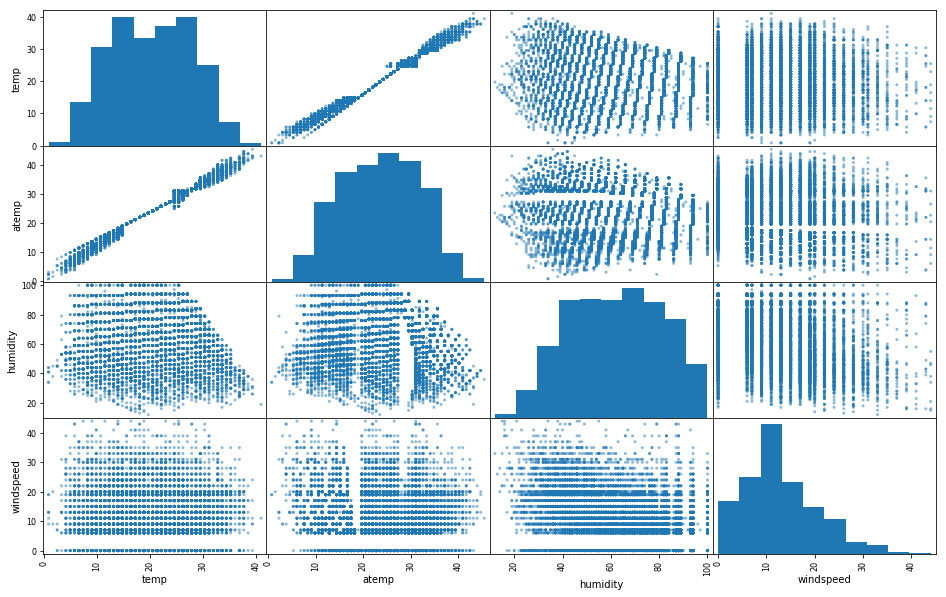

In [39]:
scatter = scatter_matrix(bikeData[['temp','atemp','humidity','windspeed']],  alpha=0.5, figsize=(16, 10))